## A short tutorial with Levelset update

Note that: the key difference of Levelset Filtration between Rips is we only need permutation when update.

In [2]:
import bats
import gudhi as gd
import dionysus as dion
import ripser
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm

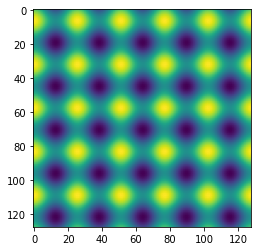

In [3]:
# generate an image
n = 128
img = np.empty((n,n), dtype=np.float64)
for i in range(n):
    for j in range(n):
        img[i,j] = np.sin(10* np.pi * i / n) + np.cos(10* np.pi * j/n)
        
plt.imshow(img)
plt.show()

In [10]:
m, n = img.shape
# Build Freudenthal triangulation of 2-dimensional grid on m x n vertices
X = bats.Freudenthal(m, n) 
# Build Lower star filtraiton on the Freudenthal triangulation
vals, imap = bats.lower_star_filtration(X, img.flatten())

In [11]:
def kendall_tau_distance(vals1, vals2):
    """
    compute kendall-tau distance between sort permutations for vals1, vals2
    vals1: List[List[float]]
    
    """
    kd = 0
    nmax = 0
    for v1, v2 in zip(vals1, vals2):
        perm1 = np.argsort(v1, kind='stable')
        perm2 = np.argsort(v2, kind='stable')

        nperm = len(perm1)
        maxswaps = (nperm * (nperm-1)) // 2

        kt = bats.kendall_tau(perm1, perm2)
        kd += kt
        nmax += maxswaps
        
    return kd, nmax

def get_kt(img1, img2):
    m, n = img1.shape
    X = bats.Freudenthal(m, n)
    vals, imap = bats.lower_star_filtration(X, img1.flatten())
    vals2, imap = bats.lower_star_filtration(X, img2.flatten())
    kd, nmax = kendall_tau_distance(vals, vals2)
    return kd / nmax # normalized Kendall-tau dist

def print_kt(img1, img2):
    print("Kendall-tau distance / max = {}".format(get_kt(img1, img2)))

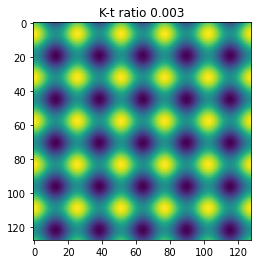

In [12]:
np.random.seed(0)
noise = np.random.randn(n,n)
sigma = 0.01
img2 = img + sigma*noise
# img2 = -img
kt = get_kt(img, img2)
plt.imshow(img2)
plt.title("K-t ratio {:.3f}".format(kt))
plt.show()

In [18]:
def time_BATS_update(img, img2, *flags):
    m, n = img.shape
    X = bats.Freudenthal(m, n)
    
    # time to compute img1 from scratch
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("img1 from scratch: {:.4f} sec.".format(t1 - t0))
    timg1 = t1 - t0
    
    # time to compute img1 from scratch
    t0 = time.monotonic()
    vals2, imap = bats.lower_star_filtration(X, img2.flatten())
    FS2 = bats.FilteredSimplicialComplex(X, vals2)
    R2 = bats.reduce(FS2, bats.F2(), *flags)
    t1 = time.monotonic()
    print("img2 from scratch: {:.4f} sec.".format(t1 - t0))
    timg1 = t1 - t0
    
    # time to update for img2
    t0 = time.monotonic()
    vals2, imap = bats.lower_star_filtration(X, img2.flatten())
    R.update_filtration(vals2)
    t1 = time.monotonic()
    print("Update on img1: {:.4f} sec.".format(t1 - t0))
    tup = t1 - t0
    
    kd, nmax = kendall_tau_distance(vals, vals2)
    print("Normalized K-t dist = {}".format(kd / nmax))
    kt_ratio = kd / nmax
    
    # return timg1, tup, kt_ratio
    
time_BATS_update(img, img2, bats.standard_reduction_flag(), 
                 bats.clearing_flag(), bats.compute_basis_flag())

img1 from scratch: 0.0792 sec.
img2 from scratch: 0.0800 sec.
Update on img1: 0.0313 sec.
Normalized K-t dist = 0.003271417187052736


Our update method is more efficient.